# SSIB analysis walk through
## To DO 0
1. Create a git repo
2. After each to do, commit and push your changes to the repo (I am going to look at this analysis using the git repo, I should see updates in this notebook at each commit corresponding to the to do)
3. Add the Rmd to the git repo as well. THE GIT REPO SHOULD NOT HAVE ANY DATA IN IT

# Notes
## Features
The X dataframe is your "features". Right now there are too many features for the number of subjects. A good rule of thumb is your features should be 10% or less than your number of samples (subjects). Since we are going to be doing training and testing, we need to limit the number of features to our final testing dataset
## Samples
This is the number of subjects in our dataset
## Targets
This is what we are trying to predict. Right now we are trying to predict the high and low SSB groups based on the features.

In [ ]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered


In [ ]:
import statsmodels.api as sm
import pandas as pd
import nilearn
import numpy as np
import glob 
import os
import pickle

from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn.manifold import TSNE

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from sklearn.model_selection import cross_val_score
from pathlib import Path

from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import seaborn as sns

import nibabel as nib
#from nilearn.input_data import NiftiLabelsMasker
#I got a warning that nilearn.input_data is deprecated, so I imported from nilearn.maskers instead
from nilearn.maskers import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import jaccard_score


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.utils import resample
import numpy as np

from sklearn.preprocessing import StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor


%matplotlib inline

# Load the data
Change the path as needed

In [ ]:
basepath = '/Users/gracer/Library/CloudStorage/OneDrive-UniversityofWyoming/0. Lab/M2AENAD Lab - Documents/RESEARCH/ABCD/Yana_SSIB_2024/'
#Yana windows
#basepath = r'C:\Users\Yanko\OneDrive - University of Wyoming\Desktop - Copy\Lab\SSIB 2024'

^ Why are you working off the OneDrive :/

In [ ]:
df = pd.read_csv(os.path.join(basepath,'data','matchedFinal.csv'))  

# To DO 1
1. Get the number of subjects call them 'n'
## REDO 1
1. Use shape to get the number of subjects without hard coding

In [ ]:
#1. gettig the n of subjects
# df.describe
# This isn't a great way to the number of subjects

2. Get a list of ROIs that include all the brain regions, sex, bmi_percentile, household income, and age  

In [ ]:
#looking for columns location to gather them into list later
rois_0 = list(df.columns)

for i in rois_0:
    print(i, df.columns.get_loc(i))

**Call this list of ROIs "ROIS"**  

In [ ]:
rois_0 = list(df.columns)


In [ ]:
#Columns needed: 1,3,5:421,425
#Don't need the subject keys!
ROIS = []
ROIS.append(rois_0[1])
ROIS.append(rois_0[3])
for i in rois_0[5:422]: #here need 422 to get 421 included! 
    ROIS.append(i)
    
# How can you do this without a loop?

ROIS.append(rois_0[425])
ROIS

3. Set sex to 0 for M and 1 for female  
4. Set ssb groups to low =0, medium = 1, and high = 2  
5. Drop the medium group  
6. Create a dataframe called 'X' that is a subset of the dataframe with only the columns in the ROIS list. 

In [ ]:
#3. Set sex to 0 for M and 1 for female  
df.replace({'sex': {'F': 1, 'M': 0}}, inplace=True)

#4. Set ssb groups to low =0, medium = 1, and high = 2  
df.replace({'ssb_group': {'low': 0, 'high': 2}}, inplace=True)

#5. Drop the medium group  
df = df[df['ssb_group'] != "medium"]

#6. Create a dataframe called 'X' that is a subset of the dataframe with only the columns in the ROIS list.
X = df[ROIS]


In [ ]:
# Transpose the DataFrame to make columns become rows
X_T = X.T
duplicates = X_T.duplicated(keep='first')
# Identifying columns to drop (all duplicates except the first occurrence)
cols_to_drop = X_T[duplicates].index
# Drop the duplicate columns from the original DataFrame
X_cleaned = X.drop(cols_to_drop, axis=1)

print(X_cleaned)

In [ ]:
#Just a checkpoint to test for mistakes
X_cleaned.shape

## Why do we have to do the step above?

I am not sure why it's done this way, but I know the purpose of this actions. <br>
The model does not take anything except numbers, and we need a df of just numbers to make it run (we could include non-numerical cols (say, IDs) as index, but this would lead to extra changes in Grace's original script and hours of wasted time.) <br>
I don't know where duplicates come from.

# Where do the duplicates come from?

# To DO 2
1. Create a dataframe 'y' with only the targets
2. Check the number of each target group

In [ ]:
# 1. Create a dataframe 'y' with only the targets
y = pd.to_numeric(df['ssb_group'])
#needed to convert to numeric because it has an object type by default

# 2. Check the number of each target group
target_counts = y.value_counts()
print("Number of subjects in each target group:")
print(target_counts)


# Train and test datasets
Get randomly generated train and test datasets
- Train 1 = train the model and feature elimination
- Train 2 = cross validate the model
- Test = test statistical differences
-- In Test we will also have trainReg and testReg 
-- We need to train and test the signifance model

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y, random_state=42)


In [ ]:
X_train1, X_train2, y_train1, y_train2 = train_test_split(X_train, y_train, random_state=42)


## What proportion of data is in:
1. X_train1?
2. X_train2?
3. X_test?

In [ ]:
# Calculate proportions of data in each dataset
proportion_X_train1 = len(X_train1) / len(X_cleaned)
proportion_X_train2 = len(X_train2) / len(X_cleaned)
proportion_X_test = len(X_test) / len(X_cleaned)

print("Proportion of data in X_train1:", proportion_X_train1)
print("Proportion of data in X_train2:", proportion_X_train2)
print("Proportion of data in X_test:", proportion_X_test)

X_cleaned is a pandas df, I have no idea why len works to find the number of rows in a df, when it's a function to tell the length of a list. But it really works. 

# To DO 3
Now we are going run the model. We are going to use an anova filter with a SVC linear kernel. 
1. Run the pipeline with the following parameters
- Make a list of anova__K parameters with a maximum value that is 10% of our X_test sample in intervals of 10 <br>
For example if our max was 1000 we would have a list from 10 to 1000 by 10 (10, 20, 30...1000)
-- call this list 'ANOVAK'
- Make a list of svc__C parameters that include 0.1, 1, 10, 100
-- call this list 'svcC'
2. With your lists run the pipeline below


In [ ]:
#1. Define the maximum value for ANOVA K parameter (10% of X_test sample)
max_anova_k = int(len(X_test) * 0.1) #made it an integer, cause it's 92.7 and float can't be used in the script below

# Make a list of ANOVA K parameters with intervals of 10
ANOVAK = list(range(10, max_anova_k+1, 10)) #range 10-max_anova_k (+1 bcs otherwise the last number won't be included to the range), steps - 10
ANOVAK

In [ ]:
#2. Make a list of svc__C parameters that include 0.1, 1, 10, 100
#call this list 'svcC'
svcC = [0.1, 1, 10, 100]

## Why are we using an ANOVA filter?

To select features based on whether they are significant or not. <br>
These features will be used as predictor values in our model to classify the ssb group.

## Why use the ANOVA and not any other type?

In [ ]:
## THIS IS THE PIPELINE ##

anova_filter = SelectKBest(f_classif)
svm = SVC(kernel='linear')

anova_svm = Pipeline([
    ('anova', anova_filter),
    ('svc', svm)
])
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': ANOVAK,  # Trying different numbers of top features
    'svc__C': svcC,  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)

print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

# To DO 4
1. Look at the "best parameters". Based on this narrow your ANOVAK and svcC lists. The ANOVAK should have the best value and the 10 digits around it. For example if the best value was 20, the next ANOVAK list should be [15,16,17,18,19,20,21,22,23,24,25]. Do the same with the best value of svcC.
2. Run the loop below (this will take a while) with your new parameters
## What is the optimum number of features and what is the optimum svc C based on your loop?

Best parameters: {'anova__k': 60, 'svc__C': 0.1}

Best cross-validation score: 0.5510857563489142


In [ ]:
ANOVAK = list(range(55, 66, 1)) #range 55-65, steps - 1
print(ANOVAK)
print(len(ANOVAK))

In [ ]:
#the range function does not work with integers, so I created a loop
# The range function only works with integers, it doesn't work with floats
#and cleaned the svcC list to fill with necessary numbers
svcC = []
for i in range(75, 126, 5):
    svcC.append(i/1000.0)
print(svcC)
print(len(svcC))

In [ ]:
# Define a range of parameters for feature selection and SVM
param_grid = {
    'anova__k': ANOVAK,  # Trying different numbers of top features
    'svc__C': svcC,  # SVM regularization parameter
}

# Setup GridSearchCV
grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
grid_search.fit(X_train1, y_train1)

bestK = []
bestC = []
for i in range(5):
    print(i)
    # Setup GridSearchCV
    grid_search = GridSearchCV(anova_svm, param_grid=param_grid, cv=10, n_jobs=4)
    grid_search.fit(X_train1, y_train1)
    bestK.append(grid_search.best_params_['anova__k'])
    bestC.append(grid_search.best_params_['svc__C'])

# To DO 5
1. Using the best parameters run the code below 
## Are these the best parameters or just the last parameters in from the best_pipeline object

In [ ]:
# Assuming anova_svm is your original pipeline
best_pipeline = Pipeline([
    ('anova', SelectKBest(f_classif)),  # You don't need to specify k here; it will be set by best_params_
    ('svc', SVC(kernel='linear'))      # No need to specify C here for the same reason
])

# Set the best parameters found for the entire pipeline
best_pipeline.set_params(**grid_search.best_params_)

# Now, retrain on the entire training set with the best parameters
best_pipeline.fit(X_train1, y_train1)

# To DO 6
1. Get the accuracy score
2. Look at the confusion matrix

In [ ]:
from sklearn.metrics import accuracy_score

# Predict on the test set
y_pred = best_pipeline.predict(X_train2)

# Evaluate the model
test_accuracy = accuracy_score(y_train2, y_pred)
print("Test set accuracy:", test_accuracy)

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
cm = confusion_matrix(y_train2, y_pred, normalize = 'true')
print(cm)

In [ ]:
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True,  cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

## What is the accuracy score telling us?

The accuracy score is 0.5330459770114943. <br> 
It means that our model predicts correctly in 53.3% cases. <br>
Still, it's considered not the perfect indicator of the model performance (especially if the groups are unbalanced, which I believe is our case, considering how we had to drop the bmi% groups + we have household income groups, which also probably aren't very balanced.  

The groups are only refering to the target groups. Also our data is pretty well matched. So why isn't the model that accurate? 

## What is the confusion matrix telling us? 
The confusion matrix is a matrix of numbers that tell us where a model gets confused. Say, of 4 classes, what if the model is predicting 1 class wrong and that's driving the accuracy score down? <br> 
So, confusion matrix gives a more detailed breakdown of the model's performance, showing how many instances were correctly or incorrectly classified, and in what way. Here's what each part of the matrix is telling us:

- **<u>0-0 True Negative (Top Left, 0.76)</u>**: The proportion of actual negatives (low ssb) that were correctly identified by the model. 76% is a pretty good number, it means that the model is relatively good at identifying the low ssb group.
- **<u> 1-0 False Positive (Top Right, 0.24)</u>**: The proportion of actual negatives (low ssb) that were incorrectly identified as positives (high ssb). This is a type I error.
- **<u> 0-1 False Negative (Bottom Left, 0.67)</u>**: The proportion of actual positives (high ssb) that were incorrectly identified as negatives (low ssb). This is a type II error and is quite high, indicating that the model often fails to identify positive instances (high ssb).
- **<u> 1-1 True Positive (Bottom Right, 0.33)</u>**: The proportion of actual positives (high ssb) that were correctly identified by the model. <br> 33% value is low, which means that our model is not very effective at correctly identifying positive instances (high ssb).

## 0s - low ssb group, 1s - high ssb group 

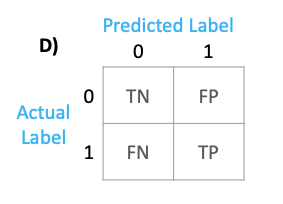

## Which target is classified the best? 

Low ssb groups

# To DO 7
1. Get the best parameters from the best model using the code below
2. Get the features as columns

In [ ]:
# Access the best set of parameters found by GridSearchCV
best_parameters = grid_search.best_params_
print("Best parameters found by GridSearchCV:", best_parameters)

# Access the best estimator directly
best_model = grid_search.best_estimator_
print("Best model:", best_model)


In [ ]:
# Access the feature selection step ('anova' in your case)
feature_selection_step = best_model.named_steps['anova']
# Get the mask of selected features (boolean array)
selected_features_mask = feature_selection_step.get_support()
selected_columns = X_train.columns[selected_features_mask]


## What features best describe the targets?


In [ ]:
selected_columns

## How are the features similar or not? 

They are all brain regions, there's no bmi or ses

# Regression
Now we are going to try to predict the SSB intake at year 2 using the features from year 1

# To DO 8
1. Subset the X_test data so that it contains only the columns selected from the feature selection above call this X_regression
2. Create a X_trainReg, X_testReg, y_trainReg, y_testReg from the X_regression and y_test
3. Run a binary logistic model

In [ ]:
# 1.Subset the X_test data to contain only the columns selected from the feature selection
X_regression = X_test[selected_columns]

#2. Create a X_trainReg, X_testReg, y_trainReg, y_testReg from the X_regression and y_test
X_trainReg, X_testReg, y_trainReg, y_testReg = train_test_split(X_regression, y_test, test_size=0.2, random_state=42)

In [ ]:
X_regression

In [ ]:
# Initialize the Logistic Regression model
model = LogisticRegression(max_iter=1000)
# Fit the model on the training data
model.fit(X_trainReg, y_trainReg)
# Predict on the test set
y_predReg = model.predict(X_testReg)

# Calculate the accuracy
accuracyReg = accuracy_score(y_testReg, y_predReg)
print(f"Accuracy: {accuracyReg}")

# Coefficients
coefficients = model.coef_
# Intercepts
intercepts = model.intercept_

# To DO 9
1. Make a dataframe of the coefficeients and have the features at the columns names
2. Add an intercept column
3. Plot the figure

In [ ]:
# 1. Make a dataframe of the coefficients and have the features as the column names
coeff_df = pd.DataFrame(coefficients, columns=X_regression.columns)

# 2. Add an intercept column
coeff_df['intercept'] = intercepts

coeff_df

In [ ]:
plt.figure(figsize=(10, 6))
sns.heatmap(coeff_df.iloc[:, :-1], annot=False, cmap='coolwarm')  # Exclude intercepts for visualization
plt.title('Coefficients of Multinomial Logistic Regression')
plt.ylabel('Class')
plt.xlabel('Feature')
plt.show()

# Summary
We now have done a basic logistic regression, but we want to see what features are signigicant predictors of SSB intake. We will use a different logistic regression package through statsmodels to get more details

In [ ]:
# Assuming X_trainReg and y_trainReg are your training data and labels
# Add constant to the features for the intercept
X_test_reg_sm = sm.add_constant(X_testReg)


# To DO 10
1. Replace 2 with 1 in the y_testReg target
2. Run the model

In [ ]:
# 1. Replace 2 with 1 in the y_testReg target
y_testReg = y_testReg.replace(2, 1)


In [ ]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_testReg, X_test_reg_sm)
result = logit_model.fit()
# Summary of the model
print(result.summary())

In [ ]:
result.params

## What features are significantly related to SSB intake?

In [ ]:
p_values = result.pvalues
significant_features = p_values[p_values < 0.05]
print(significant_features)

In [ ]:
# Making predictions
predictions = result.predict(X_test_reg_sm)
# Converting probabilities to class labels
class_predictions = np.where(predictions > 0.5, 1, 0)
# The real target assignments
real = y_testReg.to_numpy()

# To DO 11
1. Make a dataframe with two columns 'real' (the actual target classes) and 'pred' (the predicted target classes)
2. Use the jaccard score to measure the accuracy of the model

In [ ]:
# Create a dataframe with two columns 'real' and 'pred'
dfPrevReal = pd.DataFrame({
    'real': real,
    'pred': class_predictions
})

In [ ]:
jaccard = jaccard_score(dfPrevReal['real'], dfPrevReal['pred'])
print("Jaccard Similarity Score:", jaccard)


In [ ]:
## Get getting the odds ratios

In [ ]:
np.exp(result.params)


# Double check
Issue with the odds ratios from statsModels. They have impossibily high values. Possibily due to scaling. However, the brain data is all scaled (I believe). Will need to check this. Going to run the model in statsModels and scikit learn to see what is going on. 

## Checking odds ratios

### Prepro check
Going to scale the data just too see if that helps. Also will check the varience inflation factor to see if that is an issue.

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_testReg)

In [ ]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X_test_reg_sm.columns)


In [ ]:
variance = X_scaled_df.var()
print(variance)  # Low variance columns might be problematic

In [ ]:
# Assuming X_scaled is your scaled feature matrix and it's a numpy array
X_scaled_df = pd.DataFrame(X_scaled, columns=X_test_reg_sm.columns)  # Convert to DataFrame if necessary
X_scaled_df_with_const = sm.add_constant(X_scaled_df)  # Add constant for VIF calculation

vifs = pd.Series([variance_inflation_factor(X_scaled_df_with_const.values, i) 
                   for i in range(X_scaled_df_with_const.shape[1])], 
                  index=X_scaled_df_with_const.columns)

print(vifs)

In [ ]:
correlation_matrix = X_scaled_df.corr()


In [ ]:
# Set the threshold for high correlation
threshold = 0.8

# Create a boolean mask for values above the threshold
high_corr_mask = np.abs(correlation_matrix) > threshold

# Mask the diagonal and lower triangle
mask_upper_triangle = np.triu(np.ones(high_corr_mask.shape), k=1).astype(np.bool)

# Combine masks
final_mask = high_corr_mask & mask_upper_triangle


In [ ]:
# Apply mask to the correlation matrix
high_corr_pairs = correlation_matrix.where(final_mask)

# Stack the matrix and reset index to get pair-wise correlation in a readable format
stacked_corr_pairs = high_corr_pairs.stack().reset_index()
stacked_corr_pairs.columns = ['Feature 1', 'Feature 2', 'Correlation']

print(stacked_corr_pairs)

Need to drop highly correlated columns
* rsfmri_cor_ngd_au_scs_ptrh = Average correlation between auditory network and ASEG ROI right-putamen
* rsfmri_cor_ngd_rst_scs_crcxrh = Average correlation between retrosplenial temporal network and ASEG ROI right-cerebellum-cortex
* rsfmri_cor_ngd_cerc_scs_aglh = Average correlation between cingulo-opercular network and ASEG ROI left-amygdala
* rsfmri_cor_ngd_smh_scs_pllh = Average correlation between sensorimotor hand network and ASEG ROI left-pallidum
* rsfmri_cor_ngd_cerc_scs_hprh = Average correlation between cingulo-opercular network and ASEG ROI right-hippocampus
* rsfmri_cor_ngd_smh_scs_cderh = Average correlation between sensorimotor hand network and ASEG ROI right-caudate
Based on this list above we have some interest high correlations. I want to keep areas previously associated in the literature. 
## Keep
* rsfmri_cor_ngd_au_scs_ptrh = Average correlation between auditory network and ASEG ROI right-putamen
* rsfmri_cor_ngd_smh_scs_cderh = Average correlation between sensorimotor hand network and ASEG ROI right-caudate
* rsfmri_cor_ngd_smh_scs_pllh = Average correlation between sensorimotor hand network and ASEG ROI left-pallidum <- chose to keep since I dropped the other sensorimotor hand
## Drop
* rsfmri_cor_ngd_rst_scs_crcxrh = Average correlation between retrosplenial temporal network and ASEG ROI right-cerebellum-cortex
* rsfmri_cor_ngd_cerc_scs_hprh = Average correlation between cingulo-opercular network and ASEG ROI right-hippocampus <- this was a tough one, may do the analysis with both at some point
* rsfmri_cor_ngd_cerc_scs_aglh = Average correlation between cingulo-opercular network and ASEG ROI left-amygdala


In [ ]:
columns_to_drop_list = ['rsfmri_cor_ngd_rst_scs_crcxrh','rsfmri_cor_ngd_cerc_scs_hprh','rsfmri_cor_ngd_cerc_scs_aglh']

In [ ]:
X_scaled_df_reduced = X_scaled_df.drop(columns=columns_to_drop_list)


In [ ]:
# Assuming X_scaled is your scaled feature matrix and it's a numpy array
#X_scaled_df = pd.DataFrame(X_scaled, columns=X_test_reg_sm.columns)  # Convert to DataFrame if necessary
#X_scaled_df_with_const = sm.add_constant(X_scaled_df)  # Add constant for VIF calculation

vifs = pd.Series([variance_inflation_factor(X_scaled_df_reduced.values, i) 
                   for i in range(X_scaled_df_reduced.shape[1])], 
                  index=X_scaled_df_reduced.columns)

print(vifs)

In [ ]:
# Assuming df_reduced is your DataFrame after removing highly correlated columns
# and y_testReg is your target variable

# Reset index for the predictors (features)
X_aligned = X_scaled_df_reduced.reset_index(drop=True)

# Reset index for the target variable
y_aligned = y_testReg.reset_index(drop=True)

# Now, both X_aligned and y_aligned have aligned indices

### StatsModels

In [ ]:
# Assuming X_trainReg and y_trainReg are your training data and labels
# Add constant to the features for the intercept
X_aligned_sm = sm.add_constant(X_aligned)

In [ ]:
# Fit the multinomial logistic regression model
logit_model = sm.Logit(y_aligned, X_aligned)

In [ ]:
result = logit_model.fit() # error because of signularity
# Summary of the model
print(result.summary())

In [ ]:
# Fit the model with regularization
# Here we demonstrate using L1 regularization (Lasso)
# You can adjust L1 vs. L2 regularization via the L1_wt parameter (0 for L2, 1 for L1)
# alpha controls the strength of regularization (smaller values indicate stronger regularization)
result_regularized = logit_model.fit_regularized(method='l1', alpha=1, L1_wt=0)



In [ ]:
# Coefficients
coef = result_regularized.params
print("Odds Ratio:", np.exp(coef))
#Very close to the sklearn

In [ ]:
original_coefs = result_regularized.params


In [ ]:
# Number of bootstrap iterations
n_bootstraps = 1000
# Initialize array to store bootstrapped coefficients
bootstrap_coefs = np.zeros((n_bootstraps, X_aligned.shape[1]))
n_features = X_aligned.shape[1]

#### Getting the p value

In [ ]:
# y_aligned, X_aligned
# Assuming X is your predictors matrix and y is the target variable
n_features = X_aligned.shape[1]

# Initialize an array to store permuted coefficients
permuted_coefs = np.zeros((n_permutations, n_features))

for i in range(n_permutations):
    print(i)
    # Permute the target variable
    y_permuted = np.random.permutation(y_aligned)
    
    # Fit the model with the permuted target
    model_permuted = sm.Logit(y_permuted, X_aligned)
    result_permuted = model_permuted.fit_regularized(method='l1', alpha=1, L1_wt=0, disp=0)  # disp=0 suppresses output
    
    # Store the coefficients from the permuted model
    permuted_coefs[i, :] = result_permuted.params

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

#### Getting confidence intervals

In [ ]:
for i in range(n_bootstraps):
    print(i)
    # Resample the dataset with replacement
    X_resampled, y_resampled = resample(X_aligned, y_aligned)
    
    
    # Fit the model on the resampled dataset
    model_resampled = sm.Logit(y_resampled, X_resampled)
    result_resampled = model_resampled.fit_regularized(method='l1', alpha=1, L1_wt=0, disp=0)  # Turn off verbose output
    
    # Store the coefficients
    bootstrap_coefs[i, :] = result_resampled.params

In [ ]:
# Initialize an empty dictionary to store p-values with coefficient names
p_values_with_names = {}

for i, coef_name in enumerate(original_coefs.index):
    # Calculate the empirical p-value for each coefficient
    p_value = np.mean(np.abs(bootstrap_coefs[:, i]) >= np.abs(original_coefs[i]))
    # Store the p-value with the corresponding coefficient name
    p_values_with_names[coef_name] = p_value


In [ ]:
# Calculate the 2.5th and 97.5th percentiles for each coefficient
lower_bounds = np.percentile(bootstrap_coefs, 2.5, axis=0)
upper_bounds = np.percentile(bootstrap_coefs, 97.5, axis=0)

# Assuming your model's coefficients are stored in a pandas Series for easy handling
coef_names = result_regularized.params.index
ci_df = pd.DataFrame({'odds ratio': np.exp(result_regularized.params.values),
                      'lower_ci': lower_bounds,
                      'upper_ci': upper_bounds,
                     'bootP':list(p_values_with_names.values())}, index=coef_names)

print(ci_df)

In [ ]:
ci

In [ ]:
print(significant_features)


### Sklearn

In [ ]:
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)
#y_aligned, X_aligned
logisticRegr = LogisticRegression()
logisticRegr.fit(X_aligned, y_aligned)

df=pd.DataFrame({'odds_ratio':(np.exp(logisticRegr.coef_).T).tolist(),'variable':X_aligned.columns.tolist()})
df['odds_ratio'] = df['odds_ratio'].str.get(0)

df=df.sort_values('odds_ratio', ascending=False)
df

In [ ]:
from sklearn.utils import resample
import numpy as np

# Define the number of bootstrap samples
n_bootstraps = 1000
coef_matrix = []
#y_aligned, X_aligned
# Bootstrap loop
for _ in range(n_bootstraps):
    X_sample, y_sample = resample(X_aligned, y_aligned)
    logisticRegr.fit(X_sample, y_sample)
    coef_matrix.append(logisticRegr.coef_[0])

# Convert to numpy array for ease of calculation
coef_matrix = np.array(coef_matrix)

# Calculating percentiles for 95% confidence intervals
lower_bounds = np.percentile(coef_matrix, 2.5, axis=0)
upper_bounds = np.percentile(coef_matrix, 97.5, axis=0)

# Assuming you have a DataFrame 'df' with your coefficients and variable names
df['lower_ci'] = lower_bounds
df['upper_ci'] = upper_bounds

In [ ]:
df

In [ ]:
print(significant_features)
